# **Problem Statement**

**Predicting The  Retail Customer Retention Potential Level as High/Medium/Low
 AND Customer Segmentation & Pattern Extraction**

# Description
We Need to categorise each consumer according to their "RententionPotential" as high, medium, or low. Identification of the medium-level clients is crucial in this situation because it shows where taking wise action might increase the likelihood of keeping the customers who are most likely to go.

# Objectives of this Hackathon


1. To Do Exploratory Data Analysis using visualizations
2. To Build The Analytical Framework To Predict The Retail Customer Retention Potential Level as High/Medium/Low 
3. To  Segment the customers into different  categories from the standpoint of customer retention which will be used for strategic purposes
4. To Extract The Top 5 Patterns for Each Level in the Target Attribute

Import the Required Libraries

In [1]:
### Pandas and Numpy
import pandas as pd
import numpy as np

### Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

### To ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Importing Libraries
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier



In [129]:
### Mounted to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Ingestion

**Loading Train Data**

In [3]:
train = pd.read_excel("/content/drive/MyDrive/Dataset final hack/Train/Train.xlsx")
print(train.shape)
train.head()

(23820, 2)


,CustomerID,RetentionPotential
0,C37869,Low
1,C33841,Low
2,C29464,Low
3,C28158,Low
4,C22785,High


**Loading Customer Data**

In [4]:
customer_train= pd.read_excel("/content/drive/MyDrive/Dataset final hack/Train/Customerdata_Train.xlsx")
print(customer_train.shape)
customer_train.head()

(23820, 7)


,CustomerID,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay
0,C16368,CITY2,2012-09-28,0,0,0,Monday
1,C20345,CITY2,2010-12-19,1,1,1,Friday
2,C17683,CITY2,2010-10-03,0,0,0,Wednesday
3,C18647,CITY4,2010-11-27,0,0,0,Monday
4,C36692,CITY2,2009-12-04,1,1,0,Friday


**Loading Email Data**

In [5]:
email_train = pd.read_excel("/content/drive/MyDrive/Dataset final hack/Train/Emaildata_Train.xlsx")
print(email_train.shape)
email_train.head()

(517672, 6)


,CustomerID,DateOfemail,EmailType,timestamp,MailOpened,MailClicked
0,C16368,2012-09-28,WelcomeEmail,15:56:50,yes,NotApplicable
1,C20345,2010-12-19,WelcomeEmail,15:10:30,yes,NotApplicable
2,C17683,2010-10-03,WelcomeEmail,17:12:24,yes,NotApplicable
3,C18647,2010-11-27,WelcomeEmail,16:59:02,yes,NotApplicable
4,C36692,2009-12-04,WelcomeEmail,17:27:22,yes,NotApplicable


**Loading Transaction Data**

In [6]:
transactions_train = pd.read_excel("/content/drive/MyDrive/Dataset final hack/Train/transactionsdata_Train.xlsx")
print(transactions_train.shape)
transactions_train.head()

(104755, 4)


,CustomerID,DateOfOrder,timestamp,OrderQuantity
0,C16368,2013-08-11,15:17:52,15
1,C20345,2011-04-01,19:50:00,92
2,C20345,2012-06-29,15:11:56,95
3,C20345,2012-09-22,20:49:10,74
4,C20345,2011-08-23,11:50:26,81


# **Merging the Dataset**

In [7]:
# Merging The Train Data & Customer Data
ct=pd.merge(train,customer_train,on=["CustomerID"])
ct.shape

(23820, 8)

In [8]:
# Extract Total order quantity with respect to every customer
trans_order_quan = transactions_train.groupby("CustomerID")['OrderQuantity'].sum().sort_values(ascending=False)
trans_order_quan

CustomerID
C33945    51429
C22341    34060
C16810    30562
C33514    26396
C32883    26091
          ...  
C13609        1
C33021        1
C35379        1
C28639        1
C15837        0
Name: OrderQuantity, Length: 23820, dtype: int64

In [10]:
### Categorising the columns into three encoded columns by performing get_dummies and concatinating total email data.
emailtype = pd.get_dummies(email_train.EmailType,prefix="emailType")
mailClick = pd.get_dummies(email_train.MailClicked,prefix="mailClick")
mailOpened = pd.get_dummies(email_train.MailOpened,prefix="mailOpened")

emailmerged_data = pd.concat([email_train,emailtype,mailClick,mailOpened],axis = 1)

In [12]:
## Checking the top 5 records of the email merged data
emailmerged_data.head()

,CustomerID,DateOfemail,EmailType,timestamp,MailOpened,MailClicked,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes
0,C16368,2012-09-28,WelcomeEmail,15:56:50,yes,NotApplicable,0,1,1,0,0,0,1
1,C20345,2010-12-19,WelcomeEmail,15:10:30,yes,NotApplicable,0,1,1,0,0,0,1
2,C17683,2010-10-03,WelcomeEmail,17:12:24,yes,NotApplicable,0,1,1,0,0,0,1
3,C18647,2010-11-27,WelcomeEmail,16:59:02,yes,NotApplicable,0,1,1,0,0,0,1
4,C36692,2009-12-04,WelcomeEmail,17:27:22,yes,NotApplicable,0,1,1,0,0,0,1


In [13]:
## Droping the irrelavent columns after merging to remove the redundancy
emailmerged_data.drop(['EmailType','MailOpened','MailClicked','timestamp','DateOfemail'],axis=1)
emailmerged_total = emailmerged_data.groupby('CustomerID').sum().reset_index()
emailmerged_total.head()

,CustomerID,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes
0,C12116,31.0,1.0,1.0,29.0,2.0,27.0,5.0
1,C12117,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,C12118,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,C12119,41.0,1.0,1.0,37.0,4.0,28.0,14.0
4,C12120,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [14]:
# Merging the Email data and Transactionsdata
email_tran= pd.merge(emailmerged_total,trans_order_quan, on = "CustomerID")

In [164]:
# Merging the Customerdata,Traindata,Transactionsdata,Email Data
train_df = pd.merge(ct,email_tran, on = "CustomerID")
train_df

,CustomerID,RetentionPotential,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
0,C37869,Low,CITY4,2011-07-27,0,0,0,Thursday,47.0,1.0,1.0,47.0,0.0,44.0,4.0,982
1,C33841,Low,CITY1,2013-11-19,1,0,1,Thursday,10.0,1.0,1.0,8.0,2.0,4.0,7.0,43
2,C29464,Low,CITY2,2010-05-24,0,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51
3,C28158,Low,CITY1,2017-06-19,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,60
4,C22785,High,CITY2,2013-12-13,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23815,C14975,Low,CITY4,2012-03-28,0,0,0,Tuesday,47.0,1.0,1.0,47.0,0.0,47.0,1.0,57
23816,C30392,Low,CITY2,2011-01-26,0,0,0,Monday,46.0,1.0,1.0,46.0,0.0,40.0,7.0,662
23817,C41735,Low,CITY3,2013-09-21,1,0,0,Wednesday,37.0,1.0,1.0,32.0,5.0,18.0,20.0,29
23818,C26055,Low,CITY4,2013-11-23,1,0,0,Friday,26.0,1.0,1.0,23.0,3.0,20.0,7.0,55


# Data Ingestion of Test Data

**Loading Test Data**

In [16]:
test = pd.read_excel("/content/drive/MyDrive/Dataset final hack/Test/Test.xlsx")
print(test.shape)
test.head()

(5955, 1)


,CustomerID
0,C12121
1,C12132
2,C12134
3,C12135
4,C12136


**Loading Customer Test Data**

In [17]:
customer_test= pd.read_excel("/content/drive/MyDrive/Dataset final hack/Test/Customerdata_Test.xlsx")
print(customer_test.shape)
customer_test.head()

(5955, 7)


,CustomerID,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay
0,C17838,CITY4,2010-10-22,0,0,0,Thursday
1,C12403,CITY2,2008-11-17,1,1,0,Wednesday
2,C19041,CITY4,2011-01-24,0,1,0,Friday
3,C24069,CITY2,2010-09-18,0,0,0,Wednesday
4,C26718,CITY2,2010-10-02,1,0,0,Monday


**Loading Transactions Test Data**

In [18]:
transactions_test = pd.read_excel("/content/drive/MyDrive/Dataset final hack/Test/transactionsdata_Test.xlsx")
print(transactions_test.shape)
transactions_test.head()

(26768, 4)


,CustomerID,DateOfOrder,timestamp,OrderQuantity
0,C17838,2011-03-28,17:41:08,55
1,C12403,2010-10-12,15:58:02,174
2,C12403,2010-11-27,20:13:48,171
3,C12403,2011-12-09,14:34:44,166
4,C12403,2011-03-04,18:20:18,179


**Loading Email Test Data**

In [19]:
email_test = pd.read_excel("/content/drive/MyDrive/Dataset final hack/Test/Emaildata_Test.xlsx")
print(email_test.shape)
email_test.head()

(129074, 6)


,CustomerID,DateOfemail,EmailType,timestamp,MailOpened,MailClicked
0,C17838,2010-10-22,WelcomeEmail,16:59:02,yes,NotApplicable
1,C12403,2008-11-17,WelcomeEmail,12:46:56,yes,NotApplicable
2,C19041,2011-01-24,WelcomeEmail,14:35:22,yes,NotApplicable
3,C24069,2010-09-18,WelcomeEmail,12:25:26,yes,NotApplicable
4,C26718,2010-10-02,WelcomeEmail,11:55:58,yes,NotApplicable


# **Merging the Test Dataset**

In [20]:
# Merging The Test Data & Customer Test Data
ct_test=pd.merge(test,customer_test,on=["CustomerID"])
ct_test.shape

(5955, 7)

In [21]:
# Extract Total order quantity with respect to every customer
trans_order_quan_test = transactions_test.groupby("CustomerID")['OrderQuantity'].sum().sort_values(ascending=False)
trans_order_quan_test

CustomerID
C32037    57960
C21789    37146
C39420    32980
C12403    29537
C29490    26585
          ...  
C24661        1
C24487        1
C36255        1
C22253        1
C28128        1
Name: OrderQuantity, Length: 5955, dtype: int64

In [22]:
# Merging the Customerdata,Traindata,Transactionsdata
test_df = pd.merge(ct_test,trans_order_quan_test, on = "CustomerID")
test_df

,CustomerID,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,OrderQuantity
0,C12121,CITY1,2017-12-04,1,0,0,Friday,52
1,C12132,CITY3,2013-10-20,1,0,0,Tuesday,40
2,C12134,CITY3,2013-09-18,1,0,0,Monday,40
3,C12135,CITY3,2017-11-01,1,0,1,Wednesday,41
4,C12136,CITY2,2013-09-28,1,0,0,Thursday,79
...,...,...,...,...,...,...,...,...
5950,C42153,CITY1,2012-08-28,1,0,0,Sunday,379
5951,C42155,CITY4,2013-09-14,1,0,0,Thursday,41
5952,C42157,CITY4,2013-09-30,1,0,0,Tuesday,41
5953,C42167,CITY2,2016-10-28,0,0,0,Monday,502


In [23]:
## Performing Encoding Technique for Catergorising the Columns
emailtype_test= pd.get_dummies(email_test.EmailType,prefix="emailType")
mailClick_test= pd.get_dummies(email_test.MailClicked,prefix="mailClick")
mailOpened_test = pd.get_dummies(email_test.MailOpened,prefix="mailOpened")

emailmerged_data_test= pd.concat([email_test,emailtype,mailClick,mailOpened],axis = 1)

In [24]:
## Total Email Data After separating the columns
emailmerged_data_test.head()

,CustomerID,DateOfemail,EmailType,timestamp,MailOpened,MailClicked,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes
0,C17838,2010-10-22,WelcomeEmail,16:59:02,yes,NotApplicable,0,1,1,0,0,0,1
1,C12403,2008-11-17,WelcomeEmail,12:46:56,yes,NotApplicable,0,1,1,0,0,0,1
2,C19041,2011-01-24,WelcomeEmail,14:35:22,yes,NotApplicable,0,1,1,0,0,0,1
3,C24069,2010-09-18,WelcomeEmail,12:25:26,yes,NotApplicable,0,1,1,0,0,0,1
4,C26718,2010-10-02,WelcomeEmail,11:55:58,yes,NotApplicable,0,1,1,0,0,0,1


In [25]:
## Droping the Respective Repeated Features , irrelavent Features and Summing the respective columns
emailmerged_data_test.drop(['EmailType','MailOpened','MailClicked','timestamp','DateOfemail'],axis=1)
emailmerged_total_test = emailmerged_data_test.groupby('CustomerID').sum().reset_index()
emailmerged_total_test.head()

,CustomerID,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes
0,C12121,24.0,1.0,1.0,24.0,0.0,22.0,3.0
1,C12132,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,C12134,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,C12135,29.0,1.0,1.0,28.0,1.0,21.0,9.0
4,C12136,41.0,1.0,1.0,40.0,1.0,21.0,21.0


In [26]:
### Merging the Email data and Transactionsdata
email_tran_test= pd.merge(emailmerged_total_test,trans_order_quan_test, on = "CustomerID")

In [131]:
### Merging the Customerdata,Traindata,Transactionsdata,Email Data
test_df = pd.merge(ct_test,email_tran_test, on = "CustomerID")
test_df

,CustomerID,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
0,C12121,CITY1,2017-12-04,1,0,0,Friday,24.0,1.0,1.0,24.0,0.0,22.0,3.0,52
1,C12132,CITY3,2013-10-20,1,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,40
2,C12134,CITY3,2013-09-18,1,0,0,Monday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,40
3,C12135,CITY3,2017-11-01,1,0,1,Wednesday,29.0,1.0,1.0,28.0,1.0,21.0,9.0,41
4,C12136,CITY2,2013-09-28,1,0,0,Thursday,41.0,1.0,1.0,40.0,1.0,21.0,21.0,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5950,C42153,CITY1,2012-08-28,1,0,0,Sunday,0.0,11.0,11.0,0.0,0.0,0.0,11.0,379
5951,C42155,CITY4,2013-09-14,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41
5952,C42157,CITY4,2013-09-30,1,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41
5953,C42167,CITY2,2016-10-28,0,0,0,Monday,49.0,1.0,1.0,49.0,0.0,37.0,13.0,502


# Data Preprocessing For Training Dataset

In [28]:
### Checking The Shape
train_df.shape

(23820, 16)

In [29]:
### Checking The Null Values
train_df.isnull().sum()

CustomerID                   0
RetentionPotential           0
City                         0
DateOfRegistration           0
OnlineCommunication          0
AutomaticRefill              0
DoorstepDelivery             0
PreferredDeliveryDay         0
emailType_CustomizedEmail    0
emailType_WelcomeEmail       0
mailClick_NotApplicable      0
mailClick_no                 0
mailClick_yes                0
mailOpened_no                0
mailOpened_yes               0
OrderQuantity                0
dtype: int64

In [30]:
### columns
train_df.columns.values

array(['CustomerID', 'RetentionPotential', 'City', 'DateOfRegistration',
       'OnlineCommunication', 'AutomaticRefill', 'DoorstepDelivery',
       'PreferredDeliveryDay', 'emailType_CustomizedEmail',
       'emailType_WelcomeEmail', 'mailClick_NotApplicable',
       'mailClick_no', 'mailClick_yes', 'mailOpened_no', 'mailOpened_yes',
       'OrderQuantity'], dtype=object)

In [31]:
### Checking the data types of all the columns
train_df.dtypes

CustomerID                           object
RetentionPotential                   object
City                                 object
DateOfRegistration           datetime64[ns]
OnlineCommunication                   int64
AutomaticRefill                       int64
DoorstepDelivery                      int64
PreferredDeliveryDay                 object
emailType_CustomizedEmail           float64
emailType_WelcomeEmail              float64
mailClick_NotApplicable             float64
mailClick_no                        float64
mailClick_yes                       float64
mailOpened_no                       float64
mailOpened_yes                      float64
OrderQuantity                         int64
dtype: object

In [32]:
### Check the descriptive statistics of numeric variables
train_df.describe()

,OnlineCommunication,AutomaticRefill,DoorstepDelivery,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
count,23820.000000,23820.000000,23820.000000,23820.000000,23820.0,23820.0,23820.000000,23820.000000,23820.000000,23820.000000,23820.000000
mean,0.660411,0.094710,0.037615,20.732662,1.0,1.0,19.563854,1.168808,15.525273,6.207389,357.622922
std,0.473580,0.292821,0.190268,20.040546,0.0,0.0,19.168208,2.376062,17.239732,8.517405,1335.649680
min,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,1.000000,41.000000
50%,1.000000,0.000000,0.000000,19.000000,1.0,1.0,17.000000,0.000000,7.000000,2.000000,65.000000
75%,1.000000,0.000000,0.000000,40.000000,1.0,1.0,38.000000,1.000000,32.000000,8.000000,169.000000
max,1.000000,1.000000,1.000000,291.000000,1.0,1.0,249.000000,42.000000,91.000000,256.000000,51429.000000


# Data Preprocessing For Test Dataset

In [33]:
### Checking The Shape
test_df.shape

(5955, 15)

In [34]:
### Checking The Null Values
test_df.isnull().sum()

CustomerID                   0
City                         0
DateOfRegistration           0
OnlineCommunication          0
AutomaticRefill              0
DoorstepDelivery             0
PreferredDeliveryDay         0
emailType_CustomizedEmail    0
emailType_WelcomeEmail       0
mailClick_NotApplicable      0
mailClick_no                 0
mailClick_yes                0
mailOpened_no                0
mailOpened_yes               0
OrderQuantity                0
dtype: int64

In [35]:
### columns
test_df.columns.values

array(['CustomerID', 'City', 'DateOfRegistration', 'OnlineCommunication',
       'AutomaticRefill', 'DoorstepDelivery', 'PreferredDeliveryDay',
       'emailType_CustomizedEmail', 'emailType_WelcomeEmail',
       'mailClick_NotApplicable', 'mailClick_no', 'mailClick_yes',
       'mailOpened_no', 'mailOpened_yes', 'OrderQuantity'], dtype=object)

In [36]:
### Check the descriptive statistics of numeric variables
test_df.describe()

,OnlineCommunication,AutomaticRefill,DoorstepDelivery,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
count,5955.000000,5955.000000,5955.000000,5955.000000,5955.000000,5955.000000,5955.000000,5955.000000,5955.000000,5955.000000,5955.000000
mean,0.659278,0.095046,0.038959,17.674895,4.000000,4.000000,16.819144,0.855751,13.331822,8.343073,379.416793
std,0.473992,0.293303,0.193513,19.987049,11.172992,11.172992,19.078538,1.960094,16.147146,12.508755,1665.587177
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,41.000000
50%,1.000000,0.000000,0.000000,3.000000,1.000000,1.000000,3.000000,0.000000,2.000000,2.000000,63.000000
75%,1.000000,0.000000,0.000000,38.000000,1.000000,1.000000,36.000000,1.000000,27.000000,10.000000,162.000000
max,1.000000,1.000000,1.000000,279.000000,73.000000,73.000000,253.000000,26.000000,213.000000,73.000000,57960.000000


In [37]:
## Checking the dtypes of total test Data 
test_df.dtypes

CustomerID                           object
City                                 object
DateOfRegistration           datetime64[ns]
OnlineCommunication                   int64
AutomaticRefill                       int64
DoorstepDelivery                      int64
PreferredDeliveryDay                 object
emailType_CustomizedEmail           float64
emailType_WelcomeEmail              float64
mailClick_NotApplicable             float64
mailClick_no                        float64
mailClick_yes                       float64
mailOpened_no                       float64
mailOpened_yes                      float64
OrderQuantity                         int64
dtype: object

# **Analysis Of All The Excel Files For EDA**

**#### Transforming the transactionsdata Train column's datatype to datetime**

In [38]:
## Importing Calender
import calendar

In [39]:
## Checking the Dataypes in the Transactions Data
transactions_train.dtypes

CustomerID       object
DateOfOrder      object
timestamp        object
OrderQuantity     int64
dtype: object

**Observations:**

Here we have 2 Datatypes they are Object and Integer , But the Date of Order Which is in Object Datatype we need to convert this into datetime .

In [40]:
## Conversion of DateOfOrder to datetime format
transactions_train['DateOfOrder'] = pd.to_datetime(transactions_train['DateOfOrder'])
transactions_train.dtypes

CustomerID               object
DateOfOrder      datetime64[ns]
timestamp                object
OrderQuantity             int64
dtype: object

In [41]:
# Extract day month and year from dateoforder
transactions_train['day'] = transactions_train['DateOfOrder'].dt.day
transactions_train['month'] = transactions_train['DateOfOrder'].dt.month
transactions_train['year'] = transactions_train['DateOfOrder'].dt.year

**Observations:**

We Need to Do Feature Engineering , from the feature "Date of Order" we need to Extract each individual feature as "Date","Month","Year" for the better Visualizations.

In [42]:
# Extracting month  from transaction_Train for Analysing the patterns of the month feature

transactions_train['month'] = transactions_train['month'].apply(lambda x: calendar.month_abbr[x])

In [43]:
## Drop dateoforder column
transactions_train.drop(columns="DateOfOrder", inplace = True)

In [44]:
## Checking the top 10 records of Transactions Data
transactions_train.head(10)

,CustomerID,timestamp,OrderQuantity,day,month,year
0,C16368,15:17:52,15,11,Aug,2013
1,C20345,19:50:00,92,1,Apr,2011
2,C20345,15:11:56,95,29,Jun,2012
3,C20345,20:49:10,74,22,Sep,2012
4,C20345,11:50:26,81,23,Aug,2011
5,C20345,11:57:02,78,31,Oct,2011
6,C20345,18:10:26,83,25,Nov,2011
7,C20345,10:17:02,86,8,Jun,2011
8,C20345,14:48:42,85,25,May,2012
9,C20345,21:30:02,83,2,May,2011


In [45]:
## Number of OrderQuantity with respect to every month Transactions
pd.DataFrame(transactions_train.groupby('month')['OrderQuantity'].sum().sort_values(ascending=False))

,OrderQuantity
month,
Nov,953470
Oct,952084
Dec,874348
Sep,838980
Jan,779189
Aug,678259
Jul,659469
Jun,644424
May,627026


**Observations:**

In comparison to other months, the majority of orders were completed in October and November.

Text(0, 0.5, 'Count')

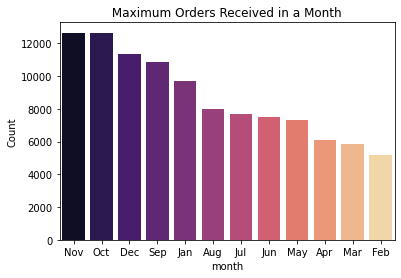

In [46]:
## Visualizing the maximum orders received in a month 
sns.countplot( x = 'month', data =transactions_train ,palette= "magma",
order = transactions_train['month'].value_counts().index)
plt.title(" Maximum Orders Received in a Month ")
plt.ylabel("Count")

In [47]:
## Converting the Number of orderquantity with respect to every year into a DataFrame
pd.DataFrame(transactions_train.groupby('year')['OrderQuantity'].sum().sort_values(ascending=False))

,OrderQuantity
year,
2013,3186085
2012,1812969
2011,1287628
2017,739904
2016,447635
2015,328761
2014,328548
2010,276890
2018,73550


**Observations:**

In comparison to Annual Years, the majority of orders were done in the year of 2013.

Text(0, 0.5, 'Count')

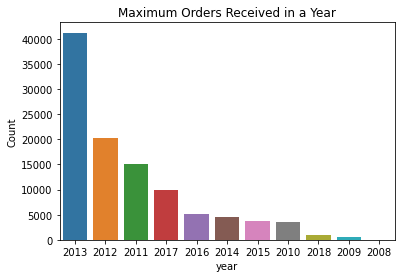

In [48]:
## Visualizing the maximum orders received in a month 
sns.countplot( x = 'year', data =transactions_train ,palette= "tab10",
order = transactions_train['year'].value_counts().index)
plt.title("Maximum Orders Received in a Year")
plt.ylabel("Count")

**Observations:**


*   In the Year of 2013 ,the Number of orders recieved is tremendiously High
*   In the Year of 2008, Throughout the entire year, no orders have been received.



 According to data from the World Bank, the inflation rate in India in 2013 was approximately 8.48%. Here is a list of the annual inflation 





rates in India from 2010 to 2020:


*   2010: 9.89%

*   2011: 13.11%

*   2012: 11.45%
*   2013: 8.48%


*   2014: 12.46%


*  2015: 14.88%

*  2016: 14.20% 
*  2017: 13.58%

*  2018: 11.70%

**Visulizations of Email Data**

In [49]:
##Checking the Datatypes of Email data
email_train.dtypes

CustomerID     object
DateOfemail    object
EmailType      object
timestamp      object
MailOpened     object
MailClicked    object
dtype: object

**Observations:**


*   All the features are of Object Datatype , But the Date of Order Which is in Object Datatype we need to convert this into datetime.



In [50]:
# Convert variable to Date
email_train['DateOfemail'] = pd.to_datetime(email_train['DateOfemail'])
email_train.dtypes

CustomerID             object
DateOfemail    datetime64[ns]
EmailType              object
timestamp              object
MailOpened             object
MailClicked            object
dtype: object

In [51]:
#### Extract date month and year from Email_Train
email_train['day'] = email_train['DateOfemail'].dt.day
email_train['month'] = email_train['DateOfemail'].dt.month
email_train['year'] = email_train['DateOfemail'].dt.year

**Observations:**



*   We Need to Do Feature Engineering , from the feature "Date of Order" we need to Extract each individual feature as "Date","Month","Year" for the better Visualizations.



In [52]:
#### Converting month names from month numbers 
import calendar
email_train['month'] = email_train['month'].apply(lambda x: calendar.month_abbr[x])

In [53]:
## Drop dateofemail column
email_train.drop(columns="DateOfemail", inplace = True)

In [54]:
## Checking the top 5 recods of Email Data
email_train.head()

,CustomerID,EmailType,timestamp,MailOpened,MailClicked,day,month,year
0,C16368,WelcomeEmail,15:56:50,yes,NotApplicable,28,Sep,2012
1,C20345,WelcomeEmail,15:10:30,yes,NotApplicable,19,Dec,2010
2,C17683,WelcomeEmail,17:12:24,yes,NotApplicable,3,Oct,2010
3,C18647,WelcomeEmail,16:59:02,yes,NotApplicable,27,Nov,2010
4,C36692,WelcomeEmail,17:27:22,yes,NotApplicable,4,Dec,2009


### <font color=green>  Maximum customers open there mail in month<font>


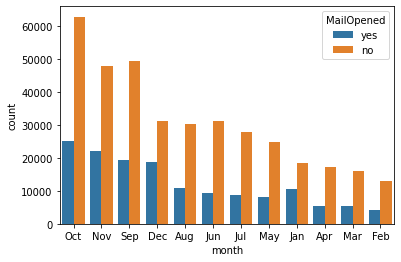

In [55]:
sns.countplot( x = 'month', data = email_train,hue="MailOpened",
 order = email_train['month'].value_counts().index);

 **Observations:**


*  The Most Customers Opened Their Mail in October.

*  The Fewest Customers Opened Their Mail in February.






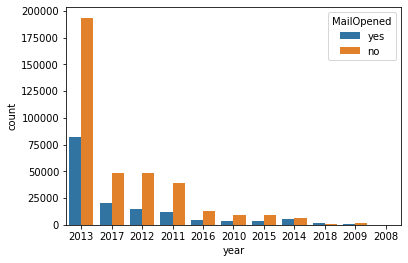

In [56]:
sns.countplot( x = 'year', data = email_train,hue="MailOpened",
 order = email_train['year'].value_counts().index);

**Observations:**



*    Compared to All the Annual years, Majority of the consumers opened their emails in the year 2013.


*   Comparing with in the year 2013, Majority of consumers who made transactions did not opened their Mails.  





# **Exploratory Data Analysis**

Low       19185
High       3756
Medium      879
Name: RetentionPotential, dtype: int64


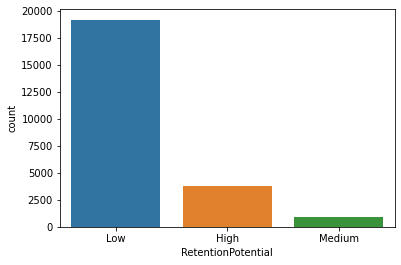

In [57]:
print(train_df['RetentionPotential'].value_counts())
sns.countplot(data = train_df, x = 'RetentionPotential')

**Observation:**


*   Our Retention Potential is Very Low





Text(0, 0.5, 'count')

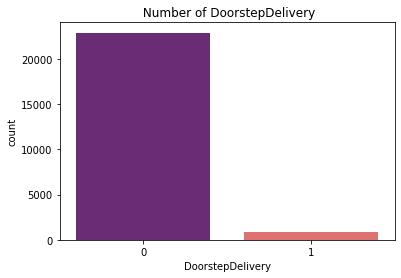

In [58]:
train_df['DoorstepDelivery'].value_counts()
sns.countplot( x = 'DoorstepDelivery', data =train_df,palette= "magma")
plt.title(" Number of DoorstepDelivery")
plt.ylabel("count")

Text(0, 0.5, 'count')

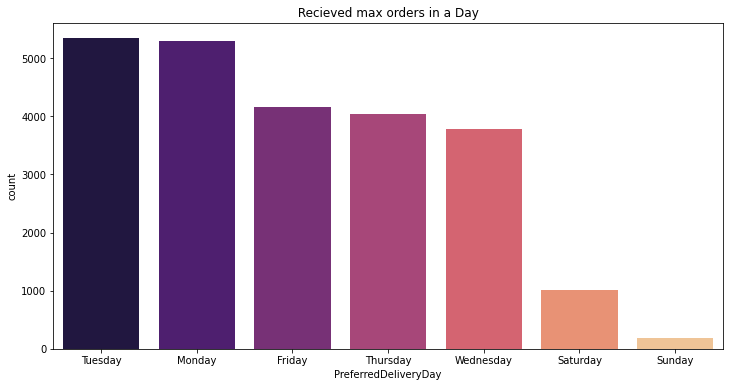

In [59]:
plt.figure(figsize=(12,6))
train_df['PreferredDeliveryDay'].value_counts()
sns.countplot( x = 'PreferredDeliveryDay', data =train_df ,palette= "magma",
order = train_df['PreferredDeliveryDay'].value_counts().index)
plt.title(" Recieved max orders in a Day ")
plt.ylabel("count")

Observation:

There are more Deliveries in the WeekDays compared to Weekends.

Text(0, 0.5, 'count')

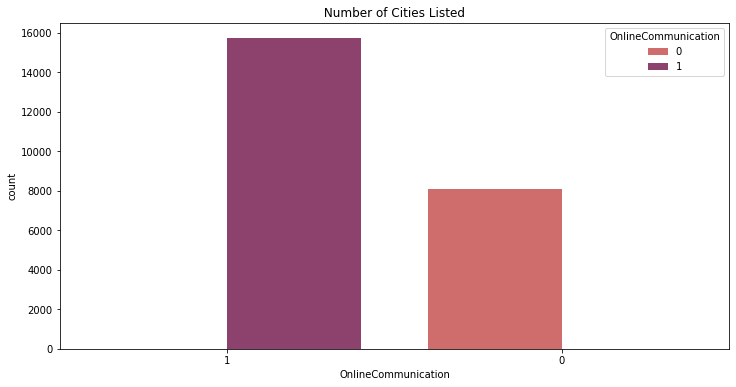

In [60]:
plt.figure(figsize=(12,6))
train_df['OnlineCommunication'].value_counts()
sns.countplot(x = 'OnlineCommunication', data =train_df ,palette= "flare",hue="OnlineCommunication",
order = train_df['OnlineCommunication'].value_counts().index)
plt.title(" Number of Cities Listed ")
plt.ylabel("count")

Text(0, 0.5, 'count')

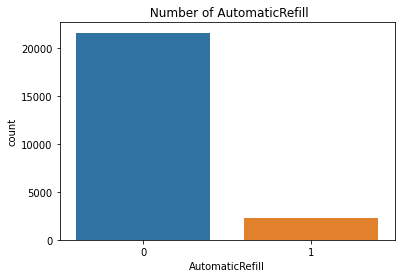

In [61]:
train_df['AutomaticRefill'].value_counts()
sns.countplot( x = 'AutomaticRefill', data=train_df ,palette= "tab10")
plt.title(" Number of AutomaticRefill")
plt.ylabel("count")

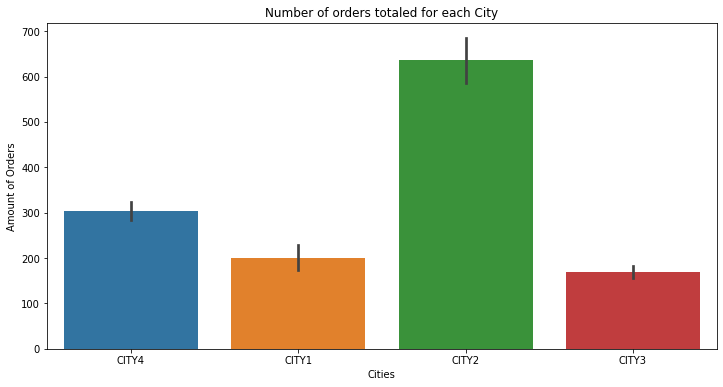

In [62]:
plt.figure(figsize=(12,6))
sns.barplot(x="City",y = "OrderQuantity",data=train_df,palette="tab10")
plt.xlabel("Cities")
plt.ylabel("Amount of Orders")
plt.title("Number of orders totaled for each City")
plt.show()

**Separating Catergorical and Numerical Variables**

In [63]:
##Segregate Numerical Features
num_columns= [fea for fea in train_df.columns if train_df[fea].dtypes != "O"]
num_columns

['DateOfRegistration',
 'OnlineCommunication',
 'AutomaticRefill',
 'DoorstepDelivery',
 'emailType_CustomizedEmail',
 'emailType_WelcomeEmail',
 'mailClick_NotApplicable',
 'mailClick_no',
 'mailClick_yes',
 'mailOpened_no',
 'mailOpened_yes',
 'OrderQuantity']

In [64]:
##Segregate Categorical Features
categ_columns = [fea for fea in train_df.columns if train_df[fea].dtypes == "O"]
categ_columns

['CustomerID', 'RetentionPotential', 'City', 'PreferredDeliveryDay']

**Separating Catergorical and Numerical Variables for Train Data**

In [65]:
##Segregate Numerical Features
num_columns= [fea for fea in train_df.columns if train_df[fea].dtypes != "O"]
num_columns

['DateOfRegistration',
 'OnlineCommunication',
 'AutomaticRefill',
 'DoorstepDelivery',
 'emailType_CustomizedEmail',
 'emailType_WelcomeEmail',
 'mailClick_NotApplicable',
 'mailClick_no',
 'mailClick_yes',
 'mailOpened_no',
 'mailOpened_yes',
 'OrderQuantity']

In [66]:
##Segregate Categorical Features
categ_columns = [fea for fea in train_df.columns if train_df[fea].dtypes == "O"]
categ_columns

['CustomerID', 'RetentionPotential', 'City', 'PreferredDeliveryDay']

In [67]:
## Converting Object type to Category
train_df[categ_columns] = train_df[categ_columns].astype('category')

In [68]:
## Droping the CustomerID, Date of Registration from train Data
train_df.drop(['CustomerID','DateOfRegistration'],axis=1,inplace=True)

In [69]:
##Dividing the dataset into independent and dependent features
x = train_df.drop(['RetentionPotential'],axis = 1)##independent features
y =train_df['RetentionPotential']##dependent features

# **Train Test Split for checking the Validation of the Model**

In [70]:
## Splitting the Dataset into Train And Test
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=10)

In [71]:
## Checking the shape for independent variables of train and test data
X_train.shape,X_test.shape

((19056, 13), (4764, 13))

In [72]:
## Checking the shape for Dependent variables of train and test data
y_train.shape,y_test.shape

((19056,), (4764,))

# **Coverting Categorical Variables to Numerical Variables**

For Ordinal Data we need to perform Label Encoding i.e respect to target column

In [73]:
## Importing the Library from sklearn 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()             ## Creating the Object 
le.fit(y_train)                 ## Fitting the LabelEncoder

y_train = le.transform(y_train) ## Applying Transform for train as well as to test
y_test = le.transform(y_test)


In [74]:
## checking the Categorical columns
categ_columns

['CustomerID', 'RetentionPotential', 'City', 'PreferredDeliveryDay']

In [75]:
## Checking the Data Types of X_train Data
X_train.dtypes

City                         category
OnlineCommunication             int64
AutomaticRefill                 int64
DoorstepDelivery                int64
PreferredDeliveryDay         category
emailType_CustomizedEmail     float64
emailType_WelcomeEmail        float64
mailClick_NotApplicable       float64
mailClick_no                  float64
mailClick_yes                 float64
mailOpened_no                 float64
mailOpened_yes                float64
OrderQuantity                   int64
dtype: object

In [76]:
## Selecting the columns which contain the Data type Category
cat_attr =X_train.select_dtypes(include=['category']).columns

In [77]:
## Checking wheather the columns are moved to  this List 
cat_attr

Index(['City', 'PreferredDeliveryDay'], dtype='object')

# **Applying One Hot Encoding for Independent Categorical Variables**

In [78]:
## Applying One Hot Encoding for Independent Categorical Variables
from sklearn.preprocessing import OneHotEncoder ## Importing the Library
enc = OneHotEncoder(drop = 'first')             ## Creating the Object and also Droping the first column to reduce the Redundancy
enc.fit(X_train[cat_attr])                      ## Fitting the One Hot Encoder Object 
X_train_ohe=enc.transform(X_train[cat_attr]).toarray() ## Applying Transform for train as well as to test and also making array
X_test_ohe=enc.transform(X_test[cat_attr]).toarray()

In [79]:
## Checking The Shape after applying One Hot Encoding for train data
X_train_ohe.shape

(19056, 9)

In [80]:
## ## Checking The Shape after applying One Hot Encoding for test data
X_test_ohe.shape

(4764, 9)

**Standardization**

In [81]:
## Selecting the Numerical features for Standardization 
num_attr = X_train.select_dtypes(include=['int64','float64']).columns

In [82]:
## Performing Standarization on Numerical Columns
from sklearn.preprocessing import StandardScaler ## Importing the Library
scaler = StandardScaler()                        ## Creating the Object
scaler.fit(X_train[num_attr])                    ## Fitting the Standarization Object
X_train_std = scaler.transform(X_train[num_attr]) ## ## Applying Transform for train as well as to test.
X_test_std = scaler.transform(X_test[num_attr])

In [83]:
## Checking the Shape after applying Standarization
print(X_train_std.shape)
print(X_test_std.shape)

(19056, 11)
(4764, 11)


**Concatination of One Hot Encoding columns & Standardization columns**

In [84]:
## Concatination of One Hot Encoding columns & Standardization columns
X_train_con = np.concatenate([X_train_std, X_train_ohe], axis=1)
X_test_con = np.concatenate([X_test_std, X_test_ohe], axis=1)

In [85]:
## Printing the shape 
print(X_train_con.shape)
print(X_test_con.shape)

(19056, 20)
(4764, 20)


# **Model Building**

# **Logistic Regression**

In [86]:
from sklearn.linear_model import LogisticRegression            
lr=LogisticRegression()                                  ## Creating the object
lr.fit(X_train_con, y_train)                             ## Fitting the Model on Train Data
train_pred_lr = lr.predict(X_train_con)                 ## Applying Predict for X_train as well as to X_test.
test_pred_lr= lr.predict(X_test_con)

In [87]:
## Definig the function for calculating model recall score
from sklearn.metrics import recall_score                 
def evaluate_model(act, pred):
    print("Recall   : ", recall_score(act, pred,average='macro'))

In [88]:
## Evaluation of Train and test
print("--Train--")
evaluate_model(y_train, train_pred_lr)
print("--Test--")
evaluate_model(y_test, test_pred_lr)

--Train--
Recall   :  0.4944329163923489
--Test--
Recall   :  0.49690828313451124


In [89]:
#performs GridsearchCV logistic regression
from sklearn.model_selection import GridSearchCV
parameters={'dual':[False,True],                       ## Creating set of Hyperparameters for the model
            'fit_intercept':[True,False],
            'random_state':list(range(0,1)),
            'max_iter':[100,50],
            'tol':[0.001,0.01]}
lr=LogisticRegression(class_weight="balanced")        ##Creating the Object and giving the class_weight = balanced due to the multiclass Imbalanced dataset
clf=GridSearchCV(lr,parameters,cv=5)                   ## Applying GridSearchCV on Logistic regression  
clf.fit(X_train_con, y_train)                          ## Fitting the model on train data
print(clf.best_params_)                                ## printing the best parameters to the model so that we also be knowing what we are applying

{'dual': False, 'fit_intercept': True, 'max_iter': 100, 'random_state': 0, 'tol': 0.001}


In [90]:
lr=LogisticRegression(fit_intercept= True, dual=False, max_iter= 100, random_state=0, tol= 0.001,class_weight="balanced") ## Assigning Hyperparameters
lr.fit(X_train_con, y_train)                               ## Fitting the model on train data
pred_test_lr=lr.predict(X_train_con)                       ## Predicting the model on train as well as validation data set
pred_train_lr=lr.predict(X_test_con)

In [91]:
# Classification Report For Train Data
from sklearn.metrics import classification_report
print(classification_report(y_train, train_pred_lr))

              precision    recall  f1-score   support

           0       0.65      0.46      0.54      3007
           1       0.87      0.96      0.91     15353
           2       0.73      0.07      0.13       696

    accuracy                           0.85     19056
   macro avg       0.75      0.49      0.53     19056
weighted avg       0.83      0.85      0.82     19056



In [92]:
# Classification Report For Test Data
from sklearn.metrics import classification_report
print(classification_report(y_test,test_pred_lr))

              precision    recall  f1-score   support

           0       0.66      0.47      0.55       749
           1       0.87      0.96      0.91      3832
           2       0.73      0.06      0.11       183

    accuracy                           0.85      4764
   macro avg       0.76      0.50      0.52      4764
weighted avg       0.83      0.85      0.82      4764



# **Random Forest Classifier**

In [93]:
### Importing Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier  
clf1 = RandomForestClassifier()                       ## Creating the object 
clf1.fit(X_train_con, y_train)                         ## Fitting the Standarization Object
                                                      ## Applying Transform for train as well as to test.              

train_pred_rf = clf1.predict(X_train_con)              ## Predict the model on train as well as validation .   
test_pred_rf = clf1.predict(X_test_con)

In [94]:
## Evaluating the Train and Test Performance
print("--Train--")                                     
evaluate_model(y_train, train_pred_rf)
print("--Test--")
evaluate_model(y_test, test_pred_rf)

--Train--
Recall   :  0.8850453155113671
--Test--
Recall   :  0.7173840414533162


**HyperParameter Tuning**

In [95]:
## ### Importing Random Forest Classifier 
from sklearn.model_selection import GridSearchCV
param_grid = {"criterion":['gini','entropy'],          ## Creating set of Hyperparameters for the model
              "n_estimators": [50,90,100],
              "max_depth":[5,8,13,20],
              "max_features":['auto','sqrt','log2'],
              "min_samples_split":[2,4],
              "min_samples_leaf":[1,2,4],
              "random_state":[0,1] }
clf3 = RandomForestClassifier()                       ## Creating the Object
clf_grid = GridSearchCV(clf3,param_grid,cv=4)         ## Applying GridSearchCV on Decision Tree classifier
clf_grid.fit(X_train_con, y_train)                    ## Fitting to the model
print(clf_grid.best_params_)                          ## printing the best parameters to the model so that we also be knowing what we are applying

{'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 1}


In [96]:
# perform gridsearchcv and cross val score on Random Forest Classifier
clf_grid = RandomForestClassifier(class_weight='balanced',
                                  criterion='entropy',
                                  max_depth = 5,                    ## Assigning set of Hyperparameters for the model
                                  max_features = 'auto',
                                  min_samples_leaf = 2,
                                  min_samples_split = 2,
                                  n_estimators =  100,
                                  random_state=1)
clf_grid.fit(X_train_con,y_train)                                   ## Fitting to the model                 
train_pred_grid = clf_grid.predict(X_train_con)                     ## Predicing the model after hyperparameter tuning on X_train as well as X_test
test_pred_grid = clf_grid.predict(X_test_con)


In [97]:
# Classification Report For Train Data
from sklearn.metrics import classification_report                  
print(classification_report(y_train, train_pred_grid))

              precision    recall  f1-score   support

           0       0.36      0.89      0.52      3007
           1       0.98      0.66      0.78     15353
           2       0.44      0.91      0.60       696

    accuracy                           0.70     19056
   macro avg       0.60      0.82      0.63     19056
weighted avg       0.86      0.70      0.74     19056



0 = High ,    1 = Low ,  2 = Medium

In [98]:
# Classification Report For Test Data
from sklearn.metrics import classification_report
print(classification_report(y_test,test_pred_grid))

              precision    recall  f1-score   support

           0       0.37      0.90      0.52       749
           1       0.98      0.66      0.79      3832
           2       0.46      0.93      0.62       183

    accuracy                           0.71      4764
   macro avg       0.60      0.83      0.64      4764
weighted avg       0.87      0.71      0.74      4764



# **Decision Tree Classifier**

In [99]:
## Model Building for Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier           
dtc= DecisionTreeClassifier(random_state=1)              ## Creating the object 
dtc.fit(X_train_con, y_train)                             ## Fitting the Standarization Object
pred_train_dtc = dtc.predict(X_train_con)                 
pred_test_dtc = dtc.predict(X_test_con)               ## ## Applying Predict on train as well as validation.

In [100]:
## Evaluation of Model Training And Testing              
print("--Train--")
evaluate_model(y_train,pred_train_dtc)
print("--Test--")
evaluate_model(y_test, pred_test_dtc)

--Train--
Recall   :  0.8923864824918275
--Test--
Recall   :  0.716619161720376


In [101]:
## perform gridsearchcv and cross val score on Decison Tree DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
parameters={'criterion':['gini', 'entropy'],
            'splitter':['best','random'],                 ## Creating set of Hyperparameters for the model
            "max_depth":[2, 3, 5, 10],
            'max_features':['auto','sqrt','log2'],
            "min_samples_split":[1,2,4],
            "min_samples_leaf":[1,2,3,4]}
dt=DecisionTreeClassifier(class_weight="balanced")       ## Creating the Object 
dt_cv=GridSearchCV(dt,parameters,cv=4)                   ## Applying GridSearchCV on Random forest classifier
dt_cv.fit(X_train_con,y_train)                           ## Fitting to the model         
pred_train_dt=dt_cv.predict(X_train_con)                 ### Predicting the model on train as well as validation data set
pred_test_dt=dt_cv.predict(X_test_con)                     

In [102]:
## Classification Report For Train Data
from sklearn.metrics import classification_report
print(classification_report(y_train,pred_train_dt ))

              precision    recall  f1-score   support

           0       0.34      0.59      0.43      3007
           1       0.97      0.72      0.83     15353
           2       0.22      0.78      0.34       696

    accuracy                           0.70     19056
   macro avg       0.51      0.70      0.53     19056
weighted avg       0.84      0.70      0.75     19056



In [103]:
## Classification Report For Test Data
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_test_dt))

              precision    recall  f1-score   support

           0       0.32      0.57      0.41       749
           1       0.97      0.71      0.82      3832
           2       0.19      0.60      0.28       183

    accuracy                           0.69      4764
   macro avg       0.49      0.63      0.50      4764
weighted avg       0.83      0.69      0.73      4764



# **K Nearest Neighbors**

In [104]:
## Model Building for KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier              
knn = KNeighborsClassifier(n_neighbors=5)                 ## Creating the Object 
knn.fit(X_train_con, y_train)                             ## Fitting the Model on Train Data
pred_train_knn = knn.predict(X_train_con)                 ## Predicting the model on train as well as validation data set
pred_test_knn = knn.predict(X_test_con)

In [105]:
## Evaluation of Model Training And Testing
print("--Train--")
evaluate_model(y_train, pred_train_knn)
print("--Test--")
evaluate_model(y_test, pred_test_knn)


--Train--
Recall   :  0.7143039756246924
--Test--
Recall   :  0.6691942555520153


In [106]:
# perform gridsearchcv and cross val score on KNeighborsClassifier
from sklearn.model_selection import GridSearchCV             ## Importing GridSearchCV For HyperParameter Tuning
parameters_knn={'n_neighbors':[4,5,6],                       
                'weights':['uniform', 'distance'],              
                'leaf_size':[12,15,18],                     ### Creating set of Hyperparameters for the model
                'n_jobs':[-1,1],
                'algorithm':['auto', 'ball_tree', 'kd_tree'] }

knn=KNeighborsClassifier(weights = "uniform")              ### Creating the Object 
clf=GridSearchCV(knn,parameters_knn)                       ## Applying GridSearchCV on KNeighborsClassifier
clf.fit(X_train_con,y_train)                               ## Fitting the Model on Train Data
print(clf.best_params_)                                    ## Printing the best parameters to the model so that we also be knowing what we are applying

{'algorithm': 'auto', 'leaf_size': 12, 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'uniform'}


In [107]:
knn=KNeighborsClassifier(algorithm= 'auto', leaf_size= 15, n_jobs= -1, n_neighbors= 6, weights = "uniform")  ## Applying best parameters on KNN classifier
knn.fit(X_train_con,y_train)                                       ##  Fitting the Model on Train Data
pred_train_knn_grid=knn.predict(X_train_con)                       ## Predicting the model on train as well as validation data set
pred_test_knn_grid=knn.predict(X_test_con)


In [108]:

# Classification Report For Train Data
from sklearn.metrics import classification_report
print(classification_report(y_train,pred_train_knn_grid))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      3007
           1       0.92      0.94      0.93     15353
           2       0.91      0.56      0.69       696

    accuracy                           0.88     19056
   macro avg       0.83      0.71      0.76     19056
weighted avg       0.88      0.88      0.88     19056



In [109]:
# Classification Report For Test Data
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_test_knn_grid))

              precision    recall  f1-score   support

           0       0.61      0.58      0.59       749
           1       0.91      0.94      0.92      3832
           2       0.87      0.54      0.67       183

    accuracy                           0.87      4764
   macro avg       0.80      0.68      0.73      4764
weighted avg       0.86      0.87      0.86      4764



# **Gradient Boosting**

In [110]:
## Importing the Gradient Boosting Classifier 
from sklearn.ensemble import GradientBoostingClassifier  ### Importing the Gradient Boosting Classifier 
gbc = GradientBoostingClassifier()                       ### Creating the Object 
gbc.fit(X_train_con,y_train)                             ##  Fitting the Model on Train Data
train_pred_gbc = gbc.predict(X_train_con)                ## Predicting the model on train as well as validation data set
test_pred_gbc = gbc.predict(X_test_con)

In [111]:
print("--Train--")
evaluate_model(y_train, train_pred_gbc)
print("--Test--")
evaluate_model(y_test, test_pred_gbc)


--Train--
Recall   :  0.7643391434943956
--Test--
Recall   :  0.7675244027400382


**HyperParameter Tuning for Gradient Boost**

In [112]:
param_grid_bg={'criterion':['squared_error','mse'],
            'n_estimators':[150],                        ### Creating set of Hyperparameters for the model
            'random_state':list(range(0,1)),
            'min_weight_fraction_leaf':[0.1,0.2] }

In [113]:
## Performing HyperParameter Tuning By Using GridSearchCV
clf4 = GradientBoostingClassifier()     ### Creating the Object 
clf_grid_gb = GridSearchCV(clf4,param_grid_bg,cv=5)    ### Applying GridSearchCV on Gradient Boosting 
clf_grid_gb.fit(X_train_con,y_train)                   ##  Fitting the Model on Train Data
train_pred_grid_gb = clf_grid_gb.predict(X_train_con)   ## Predicting the model on train as well as validation data set
test_pred_grid_gb = clf_grid_gb.predict(X_test_con)

In [114]:
# Classification Report For Train Data
from sklearn.metrics import classification_report
print(classification_report(y_train,train_pred_grid_gb))

              precision    recall  f1-score   support

           0       0.67      0.54      0.60      3007
           1       0.91      0.95      0.93     15353
           2       0.85      0.74      0.79       696

    accuracy                           0.88     19056
   macro avg       0.81      0.74      0.77     19056
weighted avg       0.87      0.88      0.87     19056



In [115]:
# Classification Report For Test Data
from sklearn.metrics import classification_report
print(classification_report(y_test,test_pred_grid_gb ))

              precision    recall  f1-score   support

           0       0.68      0.56      0.61       749
           1       0.91      0.95      0.93      3832
           2       0.85      0.71      0.77       183

    accuracy                           0.88      4764
   macro avg       0.81      0.74      0.77      4764
weighted avg       0.88      0.88      0.88      4764



# **Test Data**

In [116]:
## Checking the test_df Rows and Columns
test_df

,CustomerID,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
0,C12121,CITY1,2017-12-04,1,0,0,Friday,24.0,1.0,1.0,24.0,0.0,22.0,3.0,52
1,C12132,CITY3,2013-10-20,1,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,40
2,C12134,CITY3,2013-09-18,1,0,0,Monday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,40
3,C12135,CITY3,2017-11-01,1,0,1,Wednesday,29.0,1.0,1.0,28.0,1.0,21.0,9.0,41
4,C12136,CITY2,2013-09-28,1,0,0,Thursday,41.0,1.0,1.0,40.0,1.0,21.0,21.0,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5950,C42153,CITY1,2012-08-28,1,0,0,Sunday,0.0,11.0,11.0,0.0,0.0,0.0,11.0,379
5951,C42155,CITY4,2013-09-14,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41
5952,C42157,CITY4,2013-09-30,1,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41
5953,C42167,CITY2,2016-10-28,0,0,0,Monday,49.0,1.0,1.0,49.0,0.0,37.0,13.0,502


In [117]:
## Drooping the Customer ID as it has Unique values
test_df.drop(['CustomerID'],axis=1,inplace=True)

In [118]:
# Separating Catergorical Variables for Test Data
categorical_features_test = [fea for fea in test_df.columns if test_df[fea].dtypes == "O"]##categorical features
categorical_features_test

['City', 'PreferredDeliveryDay']

In [119]:
## Converting Object to Category of Categorical Variables
test_df[categorical_features_test] = test_df[categorical_features_test].astype('category')


In [120]:
## Selecting Categorical Variables with respect to Data types of Catergory
cat_attr_test = test_df.select_dtypes(include=['category']).columns

In [121]:
## Checking Categorical features
cat_attr_test

Index(['City', 'PreferredDeliveryDay'], dtype='object')

**Applying One Hot Encoding on Test Data**

In [122]:
## Applying One Hot Encoding on Test Data by performing Transform operation for transformations
ohe_test=enc.transform(test_df[cat_attr_test]).toarray()


In [123]:
## Checking the Shape of after performing One Hot Encoding
ohe_test.shape

(5955, 9)

**Standardization For Test Data**

In [124]:
## Selecting the numerical variables which include int64,float64
std = test_df.select_dtypes(include=['int64','float64']).columns

In [125]:
## Applying Standardization on Test Data by performing Transform operation.
test_std = scaler.transform(test_df[std])

In [126]:
## Concatinating two columns after performing standardization and one Hot Encoding
test_std_con = np.concatenate([test_std, ohe_test], axis=1)

In [127]:
## Checking the shape
test_std_con.shape

(5955, 20)

**Predicting the Model**

In [128]:
## Predicting the Model for Unseen Data or Test Data
y_pred_total = clf_grid.predict(test_std_con)

# **Customer Segmentation**

 Our goal in this Notebook is to cluster our customers to get insights in:


1.   Increasing revenue (Knowing customers who present most of our revenue)

2.   Increasing customer retention
3.   Discovering Trends and patterns


4.  Defining customers at risk




RFM (Recency, Frequency, Monetary) analysis is a proven marketing model for behavior based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy.

RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

But we can't build a rfm model due to inconsistent of Data that is required to build this model for this problem statement , This is Done by Kmeans Algorithm

# **K Means Clustering:**

In [132]:
## Checking the Merged files of Train Data 
segment_train= train_df
segment_train

,CustomerID,RetentionPotential,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
0,C37869,Low,CITY4,2011-07-27,0,0,0,Thursday,47.0,1.0,1.0,47.0,0.0,44.0,4.0,982
1,C33841,Low,CITY1,2013-11-19,1,0,1,Thursday,10.0,1.0,1.0,8.0,2.0,4.0,7.0,43
2,C29464,Low,CITY2,2010-05-24,0,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51
3,C28158,Low,CITY1,2017-06-19,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,60
4,C22785,High,CITY2,2013-12-13,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23815,C14975,Low,CITY4,2012-03-28,0,0,0,Tuesday,47.0,1.0,1.0,47.0,0.0,47.0,1.0,57
23816,C30392,Low,CITY2,2011-01-26,0,0,0,Monday,46.0,1.0,1.0,46.0,0.0,40.0,7.0,662
23817,C41735,Low,CITY3,2013-09-21,1,0,0,Wednesday,37.0,1.0,1.0,32.0,5.0,18.0,20.0,29
23818,C26055,Low,CITY4,2013-11-23,1,0,0,Friday,26.0,1.0,1.0,23.0,3.0,20.0,7.0,55


In [133]:
## Label the data with respect to target and also checking the top 5 rows 
segment_train.head(5)

,CustomerID,RetentionPotential,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
0,C37869,Low,CITY4,2011-07-27,0,0,0,Thursday,47.0,1.0,1.0,47.0,0.0,44.0,4.0,982
1,C33841,Low,CITY1,2013-11-19,1,0,1,Thursday,10.0,1.0,1.0,8.0,2.0,4.0,7.0,43
2,C29464,Low,CITY2,2010-05-24,0,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51
3,C28158,Low,CITY1,2017-06-19,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,60
4,C22785,High,CITY2,2013-12-13,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41


In [134]:
## assigning target to seg_target
seg_target = segment_train['RetentionPotential']
seg_target 

0         Low
1         Low
2         Low
3         Low
4        High
         ... 
23815     Low
23816     Low
23817     Low
23818     Low
23819    High
Name: RetentionPotential, Length: 23820, dtype: object

In [135]:
## Checking the data for verification
segment_train

,CustomerID,RetentionPotential,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
0,C37869,Low,CITY4,2011-07-27,0,0,0,Thursday,47.0,1.0,1.0,47.0,0.0,44.0,4.0,982
1,C33841,Low,CITY1,2013-11-19,1,0,1,Thursday,10.0,1.0,1.0,8.0,2.0,4.0,7.0,43
2,C29464,Low,CITY2,2010-05-24,0,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51
3,C28158,Low,CITY1,2017-06-19,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,60
4,C22785,High,CITY2,2013-12-13,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23815,C14975,Low,CITY4,2012-03-28,0,0,0,Tuesday,47.0,1.0,1.0,47.0,0.0,47.0,1.0,57
23816,C30392,Low,CITY2,2011-01-26,0,0,0,Monday,46.0,1.0,1.0,46.0,0.0,40.0,7.0,662
23817,C41735,Low,CITY3,2013-09-21,1,0,0,Wednesday,37.0,1.0,1.0,32.0,5.0,18.0,20.0,29
23818,C26055,Low,CITY4,2013-11-23,1,0,0,Friday,26.0,1.0,1.0,23.0,3.0,20.0,7.0,55


In [136]:
## Dropping the Target column Retential Potential as we need to make this as a Unsupervised ML Model and also DateOfRegistration,'CustomerID'
segment_train.drop(['RetentionPotential','DateOfRegistration','CustomerID'],axis=1,inplace=True)

In [137]:
# Separating Catergorical Variables for Test Data
categ_ord= [fea for fea in segment_train.columns if segment_train[fea].dtypes == "O"]  ##categorical features
categ_ord

['City', 'PreferredDeliveryDay']

In [138]:
## Converting Object to Category of Categorical Variables
segment_train[categ_ord] = segment_train[categ_ord].astype('category')


In [139]:
#Separating Catergorical Variables of Training Data
cat_seg = segment_train.select_dtypes(include=['category']).columns

In [140]:
## Checking the Categorical that should be given for Encoding
cat_seg

Index(['City', 'PreferredDeliveryDay'], dtype='object')

In [141]:
## Applying One Hot Encoding on Test Data by performing Transform operation for transformations
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop = 'first')
enc.fit(segment_train[cat_seg])
train_df_oh_seg = enc.transform(segment_train[cat_seg]).toarray()

In [142]:
## Printing the shape of the train_df after performing One Hot Encoding
print(train_df_oh_seg.shape)


(23820, 9)


In [143]:
## Selecting the numerical variables which include int64,float64
num_seg = segment_train.select_dtypes(include=['int64','float64']).columns

In [144]:
## Applying Standardization on Test Data by performing Transform operation.
from sklearn.preprocessing import StandardScaler
scaler_seg= StandardScaler()
scaler_seg.fit(segment_train[num_seg])
train_df_std = scaler_seg.transform(segment_train[num_seg])

In [145]:
## Printing the shape of the train_df after performing Standardization.
print(train_df_std.shape)

(23820, 11)


In [146]:
## ## Concatinating two columns after performing standardization and one Hot Encoding.
train_df = np.concatenate([train_df_std, train_df_oh_seg], axis=1)
print(train_df.shape)


(23820, 20)


# **Model Building of KMeans Algorithm**

In [147]:
## importing KMeans Algorithm
from sklearn.cluster import KMeans
kmeans_object = KMeans(n_clusters=3, random_state=1240)
kmeans_object.fit(train_df)

KMeans(n_clusters=3, random_state=1240)

In [148]:
## checking the target array
kmeans_clusters = kmeans_object.labels_
kmeans_clusters

array([1, 0, 0, ..., 2, 1, 0], dtype=int32)

In [149]:
## Checking the unique clusters and the counts of each class
np.unique(kmeans_clusters, return_counts=True)

(array([0, 1, 2], dtype=int32), array([11943,  8229,  3648]))

In [150]:
## Converting the columns to DataFrame 
kmeans_results = pd.DataFrame({"RetentionPotential":seg_target,"kmeans_cluster":kmeans_clusters})
kmeans_results.head(10)

,RetentionPotential,kmeans_cluster
0,Low,1
1,Low,0
2,Low,0
3,Low,0
4,High,0
5,Low,2
6,Low,0
7,Low,1
8,Low,0
9,Low,2


In [151]:
kmeans_results.shape

(23820, 2)

**Kmeans initailizes centroids randomly and also the centrids may initialized near to each other and due to this it will endup in forming only one or two clusters**

In [152]:
## Predicting the model on train Dataset
clusters = kmeans_object.predict(train_df)

In [153]:
#### Importing  Silhouette score as a metric because  it is a Unsupervised ML Model for a Train Data
from sklearn.metrics import silhouette_samples, silhouette_score

In [154]:
## The Evaluation Metric Here is Silhouette score as it is a Unsupervised ML Model for a Training Data
silhouette_avg = silhouette_score( train_df, clusters)
print('score de silhouette for Training Data : {:<.3f}'.format(silhouette_avg))

score de silhouette for Training Data : 0.321


# **KMeans++  Algorithm**

In [155]:
## importing KMeans Algorithm
from sklearn.cluster import KMeans
kmeans_plus = KMeans(init='k-means++',n_clusters=3, random_state=12 , max_iter=1200, algorithm='auto',n_init=80)
kmeans_plus.fit(train_df)

KMeans(max_iter=1200, n_clusters=3, n_init=80, random_state=12)

In [156]:
## checking the target array
kmeans_clusters_plus = kmeans_plus.labels_
kmeans_clusters_plus

array([2, 0, 1, ..., 2, 2, 1], dtype=int32)

In [157]:
## Converting the columns to DataFrame 
kmeans_results_plus = pd.DataFrame({"Target":seg_target,"kmeans_cluster":kmeans_clusters_plus})
kmeans_results_plus.head(10)

,Target,kmeans_cluster
0,Low,2
1,Low,0
2,Low,1
3,Low,1
4,High,1
5,Low,2
6,Low,1
7,Low,2
8,Low,1
9,Low,2


In [158]:
kmeans_results_plus.shape

(23820, 2)

In [159]:
## Predicting the model on train Dataset
clusters_plus= kmeans_plus.predict(train_df)

In [160]:
## The Evaluation Metric Here is Silhouette score as it is a Unsupervised ML Model for a Training Data
silhouette_avg = silhouette_score( train_df, clusters_plus)
print('score de silhouette for Training Data : {:<.3f}'.format(silhouette_avg))

score de silhouette for Training Data : 0.336


In [161]:
kmeans_results_plus.kmeans_cluster.value_counts()

1    11645
2    11279
0      896
Name: kmeans_cluster, dtype: int64

# **Add Cluster Labels to Original Data**

In [165]:
 ## Reading the Orginal Merged Trian data
 train_df

,CustomerID,RetentionPotential,City,DateOfRegistration,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
0,C37869,Low,CITY4,2011-07-27,0,0,0,Thursday,47.0,1.0,1.0,47.0,0.0,44.0,4.0,982
1,C33841,Low,CITY1,2013-11-19,1,0,1,Thursday,10.0,1.0,1.0,8.0,2.0,4.0,7.0,43
2,C29464,Low,CITY2,2010-05-24,0,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51
3,C28158,Low,CITY1,2017-06-19,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,60
4,C22785,High,CITY2,2013-12-13,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23815,C14975,Low,CITY4,2012-03-28,0,0,0,Tuesday,47.0,1.0,1.0,47.0,0.0,47.0,1.0,57
23816,C30392,Low,CITY2,2011-01-26,0,0,0,Monday,46.0,1.0,1.0,46.0,0.0,40.0,7.0,662
23817,C41735,Low,CITY3,2013-09-21,1,0,0,Wednesday,37.0,1.0,1.0,32.0,5.0,18.0,20.0,29
23818,C26055,Low,CITY4,2013-11-23,1,0,0,Friday,26.0,1.0,1.0,23.0,3.0,20.0,7.0,55


In [166]:
## Droping the unique ID's and Date of Registration
train_df.drop(['CustomerID','DateOfRegistration'],axis=1,inplace=True)

In [167]:
## Checking the columns 
train_df

,RetentionPotential,City,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
0,Low,CITY4,0,0,0,Thursday,47.0,1.0,1.0,47.0,0.0,44.0,4.0,982
1,Low,CITY1,1,0,1,Thursday,10.0,1.0,1.0,8.0,2.0,4.0,7.0,43
2,Low,CITY2,0,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51
3,Low,CITY1,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,60
4,High,CITY2,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23815,Low,CITY4,0,0,0,Tuesday,47.0,1.0,1.0,47.0,0.0,47.0,1.0,57
23816,Low,CITY2,0,0,0,Monday,46.0,1.0,1.0,46.0,0.0,40.0,7.0,662
23817,Low,CITY3,1,0,0,Wednesday,37.0,1.0,1.0,32.0,5.0,18.0,20.0,29
23818,Low,CITY4,1,0,0,Friday,26.0,1.0,1.0,23.0,3.0,20.0,7.0,55


In [168]:
## Kmeans cluster labels 
kmeans_results

,RetentionPotential,kmeans_cluster
0,Low,1
1,Low,0
2,Low,0
3,Low,0
4,High,0
...,...,...
23815,Low,1
23816,Low,1
23817,Low,2
23818,Low,1


In [170]:
## Concatinating the two Data Frames and also checking the shape , head
Total_train = pd.concat([train_df,kmeans_results], axis=1)
print(Total_train.shape)
Total_train.head()

(23820, 16)


,RetentionPotential,City,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity,RetentionPotential,kmeans_cluster
0,Low,CITY4,0,0,0,Thursday,47.0,1.0,1.0,47.0,0.0,44.0,4.0,982,Low,1
1,Low,CITY1,1,0,1,Thursday,10.0,1.0,1.0,8.0,2.0,4.0,7.0,43,Low,0
2,Low,CITY2,0,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51,Low,0
3,Low,CITY1,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,60,Low,0
4,High,CITY2,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41,High,0


In [171]:
## Checking the Group of  2
Total_train[Total_train.kmeans_cluster ==2]

,RetentionPotential,City,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity,RetentionPotential,kmeans_cluster
5,Low,CITY3,1,0,0,Thursday,45.0,1.0,1.0,35.0,10.0,23.0,23.0,266,Low,2
9,Low,CITY4,1,0,0,Thursday,32.0,1.0,1.0,30.0,2.0,3.0,30.0,113,Low,2
12,Low,CITY4,0,0,0,Wednesday,34.0,1.0,1.0,34.0,0.0,8.0,27.0,174,Low,2
15,Low,CITY2,0,0,0,Monday,35.0,1.0,1.0,32.0,3.0,13.0,23.0,124,Low,2
19,Low,CITY2,1,1,0,Monday,39.0,1.0,1.0,35.0,4.0,10.0,30.0,5870,Low,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23805,Low,CITY3,0,0,0,Monday,34.0,1.0,1.0,29.0,5.0,18.0,17.0,178,Low,2
23807,Low,CITY4,1,0,0,Friday,24.0,1.0,1.0,22.0,2.0,11.0,14.0,128,Low,2
23808,Low,CITY3,0,0,0,Tuesday,41.0,1.0,1.0,35.0,6.0,26.0,16.0,355,Low,2
23814,Low,CITY3,0,0,0,Monday,33.0,1.0,1.0,31.0,2.0,13.0,21.0,40,Low,2


In [172]:
## Checking the Group of  Clustered Customers
Total_train[Total_train.kmeans_cluster ==0]

,RetentionPotential,City,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity,RetentionPotential,kmeans_cluster
1,Low,CITY1,1,0,1,Thursday,10.0,1.0,1.0,8.0,2.0,4.0,7.0,43,Low,0
2,Low,CITY2,0,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51,Low,0
3,Low,CITY1,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,60,Low,0
4,High,CITY2,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41,High,0
6,Low,CITY4,1,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,42,Low,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23801,Low,CITY4,1,0,0,Friday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41,Low,0
23806,Medium,CITY3,1,0,0,Wednesday,7.0,1.0,1.0,4.0,3.0,3.0,5.0,278,Medium,0
23809,Low,CITY2,1,1,0,Monday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41,Low,0
23813,Low,CITY3,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,26,Low,0


In [173]:
## Checking the Group of  Clustered Customers
Total_train[Total_train.kmeans_cluster ==1]
Total_train.head()

,RetentionPotential,City,OnlineCommunication,AutomaticRefill,DoorstepDelivery,PreferredDeliveryDay,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity,RetentionPotential,kmeans_cluster
0,Low,CITY4,0,0,0,Thursday,47.0,1.0,1.0,47.0,0.0,44.0,4.0,982,Low,1
1,Low,CITY1,1,0,1,Thursday,10.0,1.0,1.0,8.0,2.0,4.0,7.0,43,Low,0
2,Low,CITY2,0,0,0,Tuesday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,51,Low,0
3,Low,CITY1,1,0,0,Saturday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,60,Low,0
4,High,CITY2,1,0,0,Thursday,0.0,1.0,1.0,0.0,0.0,0.0,1.0,41,High,0


In [175]:
## Grouping the customers nased on clusters and aggrigating every column will Give the clusters .
ClusterLevelAggrigate = Total_train.groupby(['kmeans_cluster']).sum().reset_index()
ClusterLevelAggrigate

,kmeans_cluster,OnlineCommunication,AutomaticRefill,DoorstepDelivery,emailType_CustomizedEmail,emailType_WelcomeEmail,mailClick_NotApplicable,mailClick_no,mailClick_yes,mailOpened_no,mailOpened_yes,OrderQuantity
0,0,8239,1045,306,25448.0,11943.0,11943.0,24037.0,1411.0,18819.0,18572.0,1597488
1,1,4682,362,108,338089.0,8229.0,8229.0,329686.0,8403.0,295816.0,50502.0,3131466
2,2,2810,849,482,130315.0,3648.0,3648.0,112288.0,18027.0,55177.0,78786.0,3789624


# **Conclusion:**
 

*   I can see the patterns of the customer doing there transations based on order Quantity
*   So I can cluster the Groups 0 as Low.

*  So I can cluster the Groups 1 as Medium.
*  So I can cluster the Groups 2 as High.



* Here identifying the medium level customers is important as this category  indicates where some intelligent action may lead to high possibility of retaining the customers who are likely to churn.

They are :




*   Offer personalized discounts or incentives
*   Enhance the customer experience


*   Develop a strong brand identity
*   Build a customer loyalty




